# Shifted Attention Decoder-only transformer experiments

This notebook contains experiments of the shifted attention decoder-only transformer applied in the context of timeseries forecasting. In this notebook, you will find the following experiments:

We train a model on the `SimplePeriodicDataset` with non-overlapping source and target with a few different values of the shift parameter

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [26]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.Transformer.ShiftAttention import ShiftAttention
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

In [27]:
# configs
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif  torch.cuda.is_available():    
    device = 'cuda'
else:
    device = 'cpu'
    
x = torch.ones(1, device=device)
print(x)

# transformer configs
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = emb_size // n_heads          # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

# meta data to store images
FOLDER = "shift_attention_conv_emb"

tensor([1.], device='mps:0')


# 1 shift

In [28]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries
n_shifts = 1                            # number of shifts in shift attention

# attention module
_attention = ShiftAttention(shift=n_shifts)

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

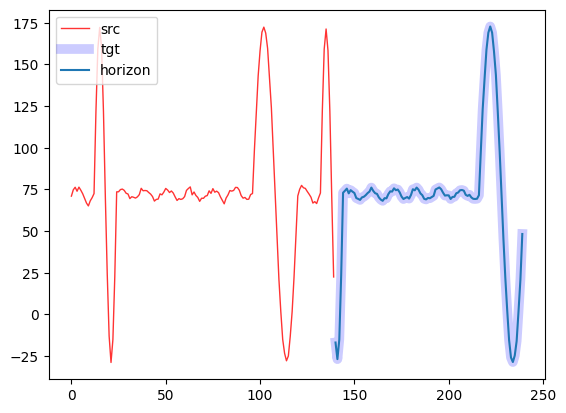

In [29]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [30]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [31]:
early_stopper = EarlyStopping(patience=30)

for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
        
model = early_stopper.best_model

epoch=0	train_loss=2436.7828	val_loss=1581.4196	train_mape_loss=15.9259	val_mape_loss=13.6896	R_p=['0.3286', '0.4115']
epoch=1	train_loss=1506.0874	val_loss=1591.0760	train_mape_loss=19.6285	val_mape_loss=13.5591	R_p=['0.3347', '0.4244']
epoch=2	train_loss=1508.7260	val_loss=1599.6178	train_mape_loss=19.6212	val_mape_loss=13.3749	R_p=['0.3404', '0.4365']
epoch=3	train_loss=1467.9584	val_loss=1401.5796	train_mape_loss=19.8997	val_mape_loss=14.3239	R_p=['0.2882', '0.3487']
epoch=4	train_loss=1298.6440	val_loss=1252.3655	train_mape_loss=20.3345	val_mape_loss=14.0866	R_p=['0.2574', '0.3308']
epoch=5	train_loss=1247.7132	val_loss=1214.5755	train_mape_loss=20.4116	val_mape_loss=14.2923	R_p=['0.2543', '0.3297']
epoch=6	train_loss=1178.8825	val_loss=1187.0221	train_mape_loss=20.4069	val_mape_loss=14.3009	R_p=['0.2467', '0.3105']
epoch=7	train_loss=1142.4960	val_loss=1200.6679	train_mape_loss=20.5210	val_mape_loss=14.0635	R_p=['0.2671', '0.3450']
epoch=8	train_loss=1100.8718	val_loss=1161.1001	

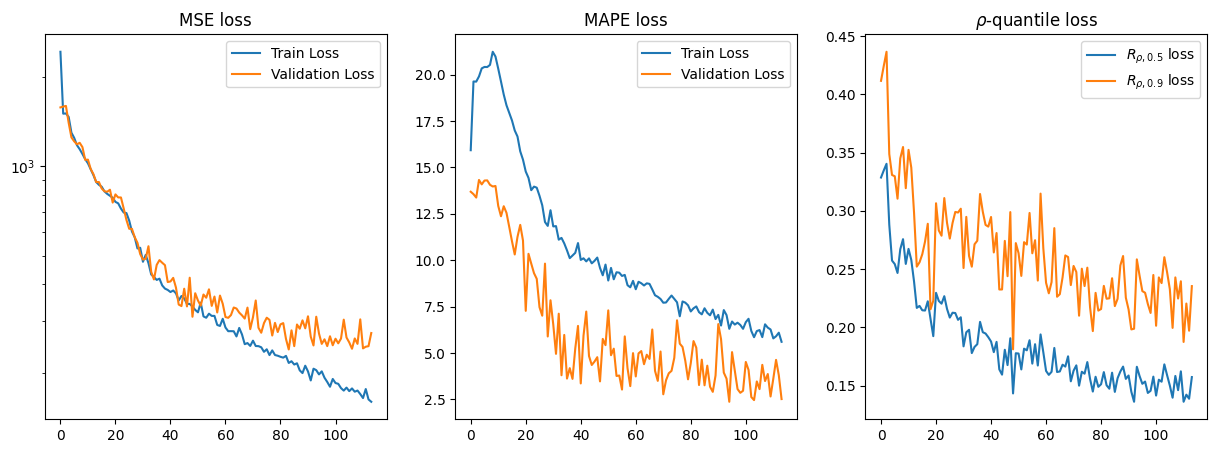

In [32]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [33]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(251.4679464111328,
 4.37930694437027,
 [0.14903618395328522, 0.22773025929927826])

### Predict

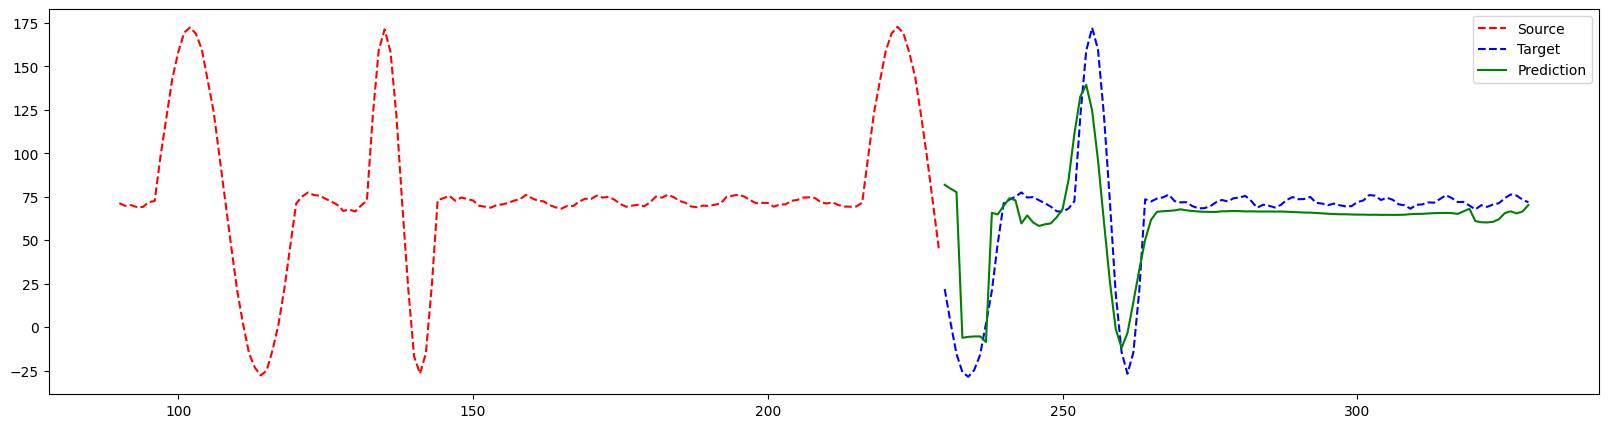

In [34]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [35]:
inspect_step = 0

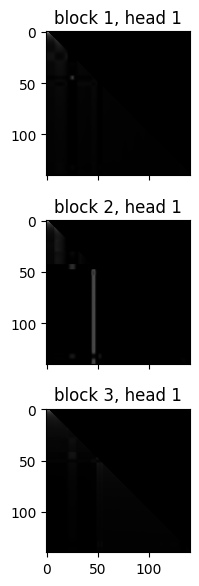

In [36]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

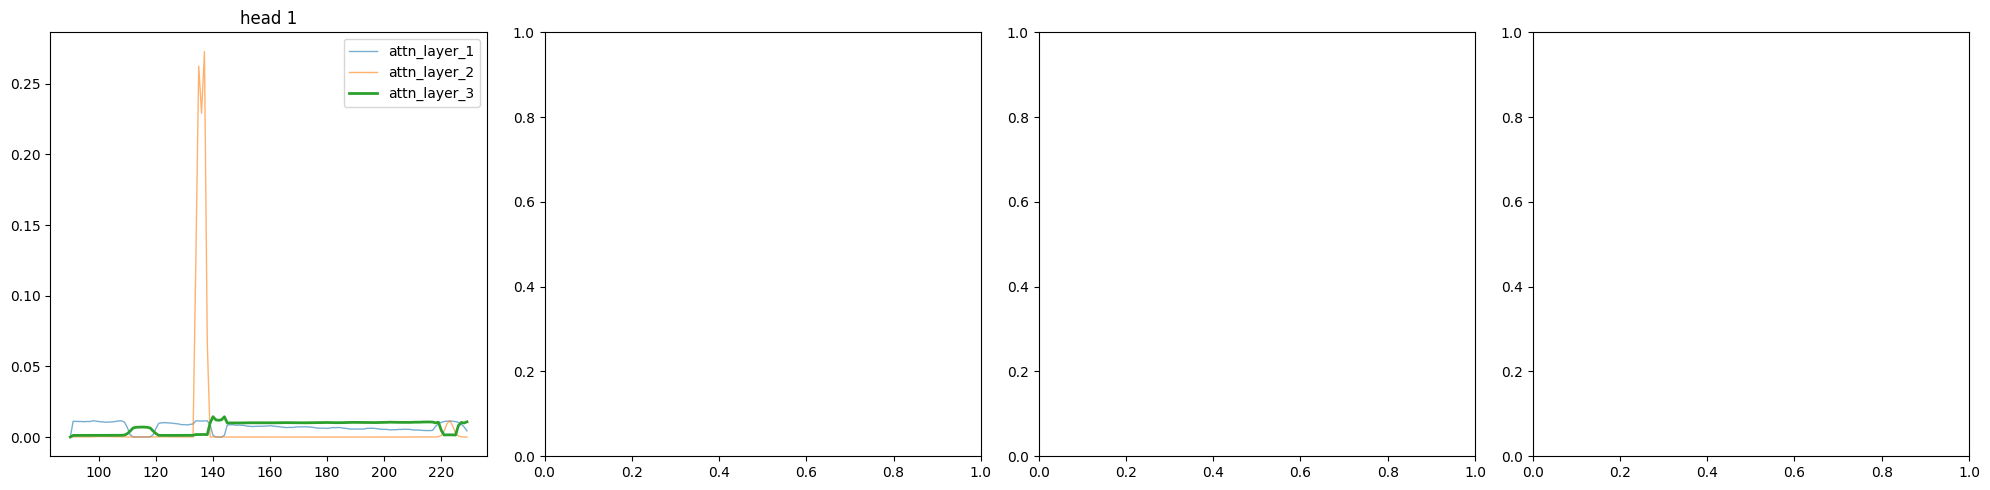

In [37]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

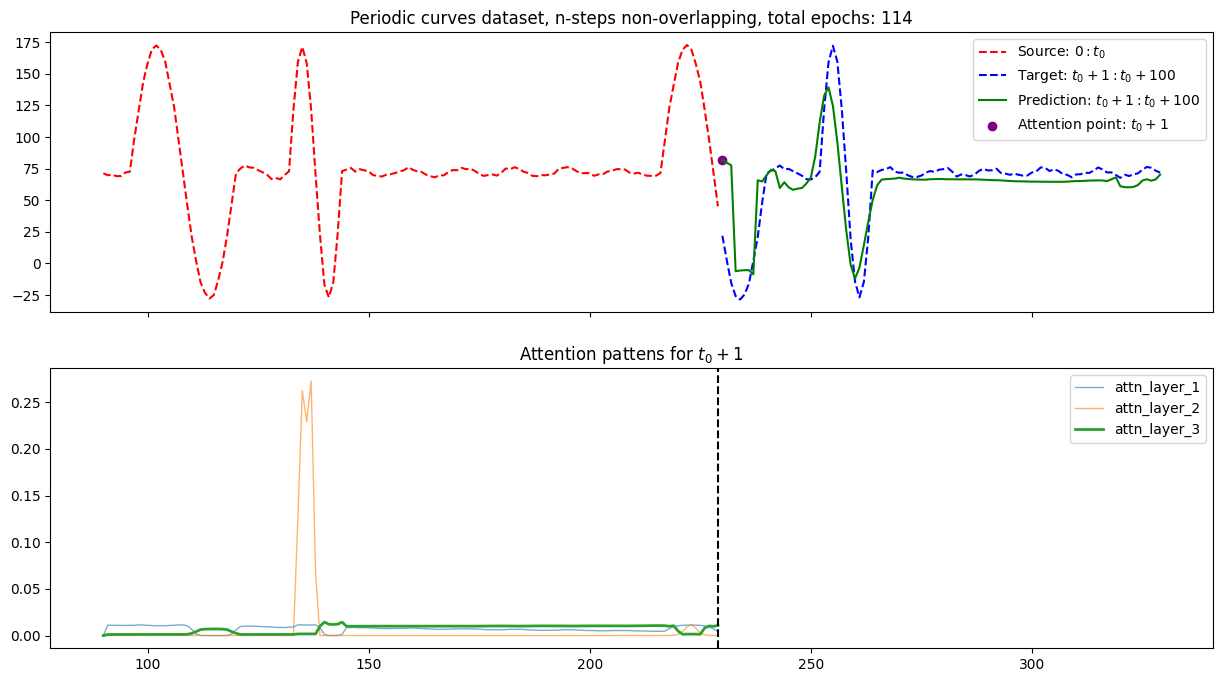

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{str(n_shifts)}_shifted_attn.pdf", dpi=1200)

# 2 shifts

In [39]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140  # sequence length of each sample
n_timeseries = 1  # number of multivariate time series
shift = 100  # number of steps to predict at once
total_length = 6000 + seq_len + shift  # full length of timeseries
n_shifts = 2  # number of shifts in shift attention

# attention module
_attention = ShiftAttention(shift=n_shifts)

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100,
                                   mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

### Training setup

In [40]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [41]:
early_stopper.reset()

for epoch in range(EPOCHS):
    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift,
                                                      device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(
        f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
        
model = early_stopper.best_model

epoch=0	train_loss=2450.5981	val_loss=1568.3301	train_mape_loss=1.9723	val_mape_loss=1.9243	R_p=['0.3343', '0.4244']
epoch=1	train_loss=1503.4703	val_loss=1555.2860	train_mape_loss=2.2446	val_mape_loss=1.9358	R_p=['0.3269', '0.4090']
epoch=2	train_loss=1494.9163	val_loss=1501.4592	train_mape_loss=2.2410	val_mape_loss=1.9504	R_p=['0.3067', '0.3696']
epoch=3	train_loss=1393.9199	val_loss=1385.8551	train_mape_loss=2.1066	val_mape_loss=1.6463	R_p=['0.2993', '0.3879']
epoch=4	train_loss=1324.4281	val_loss=1476.4274	train_mape_loss=1.9414	val_mape_loss=1.4282	R_p=['0.3041', '0.4138']
epoch=5	train_loss=1258.0564	val_loss=1297.9386	train_mape_loss=1.7945	val_mape_loss=1.2567	R_p=['0.2637', '0.3467']
epoch=6	train_loss=1198.9383	val_loss=1241.4660	train_mape_loss=1.6219	val_mape_loss=1.2093	R_p=['0.2589', '0.3396']
epoch=7	train_loss=1167.9458	val_loss=1180.8755	train_mape_loss=1.5699	val_mape_loss=1.2335	R_p=['0.2418', '0.2981']
epoch=8	train_loss=1160.3644	val_loss=1183.0339	train_mape_loss=

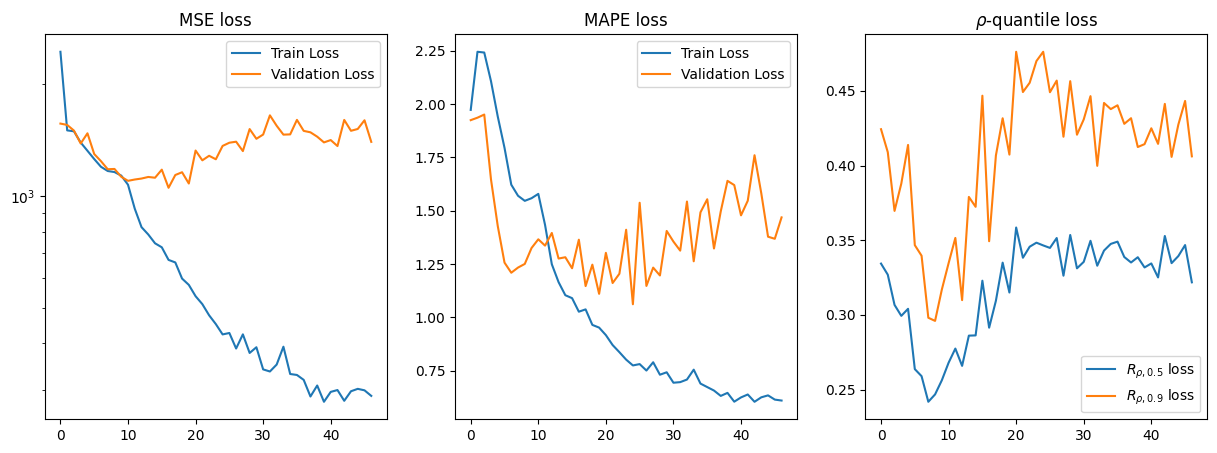

In [42]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [43]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(1075.12688671875, 1.523633687019348, [0.2967555522918701, 0.35764080286026])

### Predict

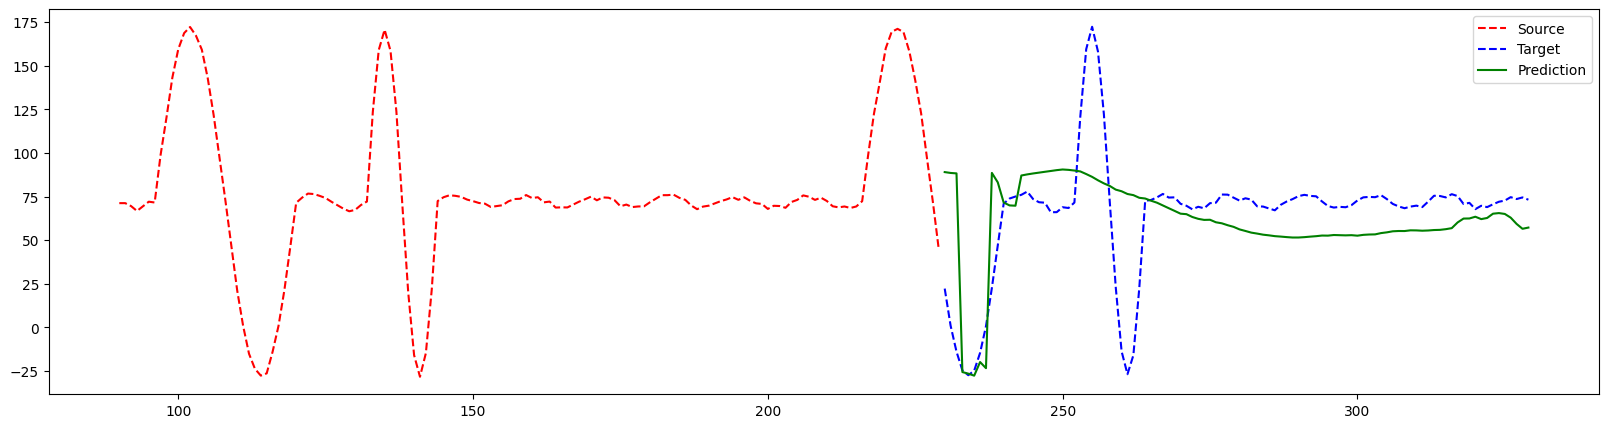

In [44]:
idx = 90  # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [45]:
inspect_step = 0

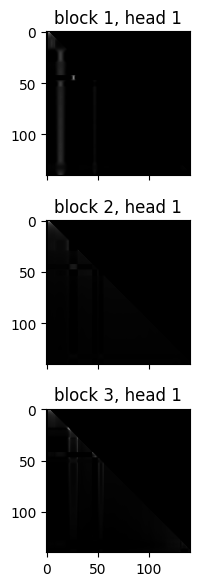

In [46]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2 * n_heads, 2 * n_layers), sharex=True, sharey=True,
                         squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i + 1}, head {j + 1}")
plt.tight_layout()

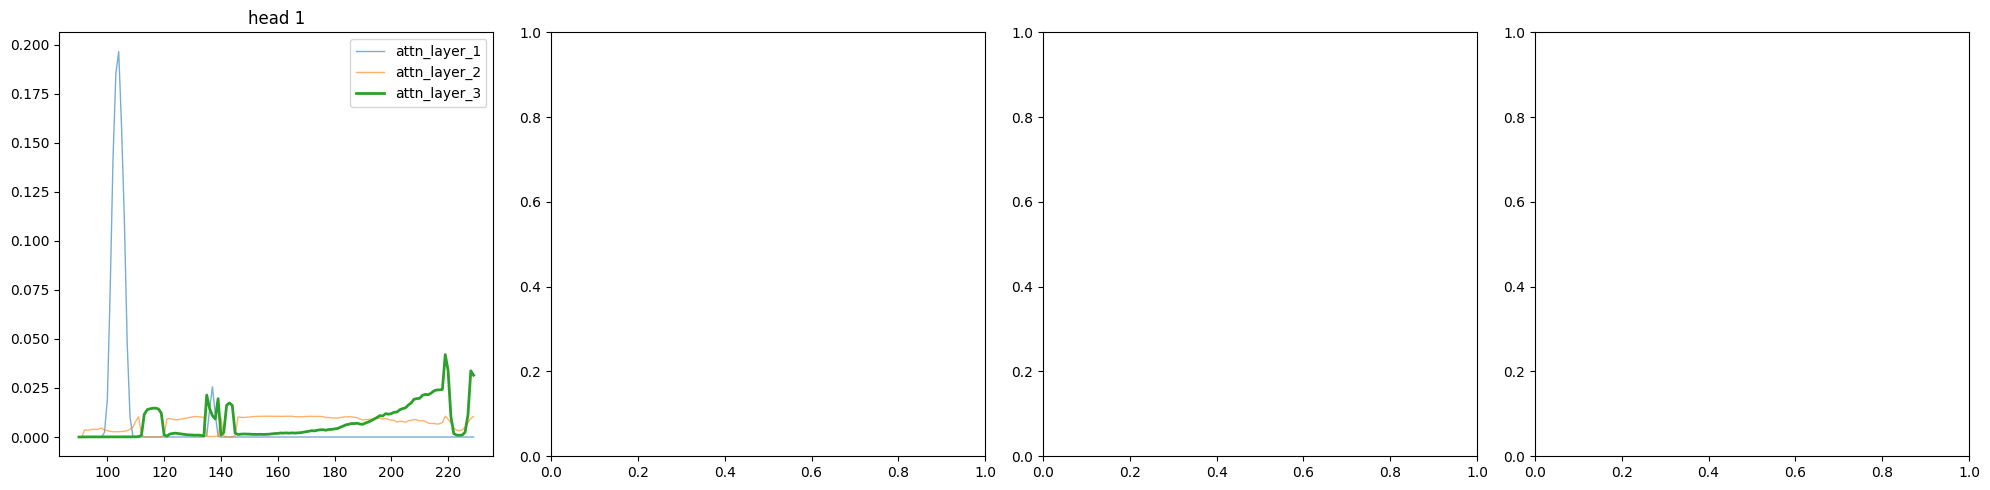

In [47]:
fig, axes = plt.subplots(n_heads // 4 + 1, 4, figsize=(20, 5 + n_heads // 4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step - 1, :].cpu()
        if i == n_layers - 1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i + 1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i + 1}')
        ax.set_title(f"head {j + 1}")
    ax.legend()

plt.tight_layout()

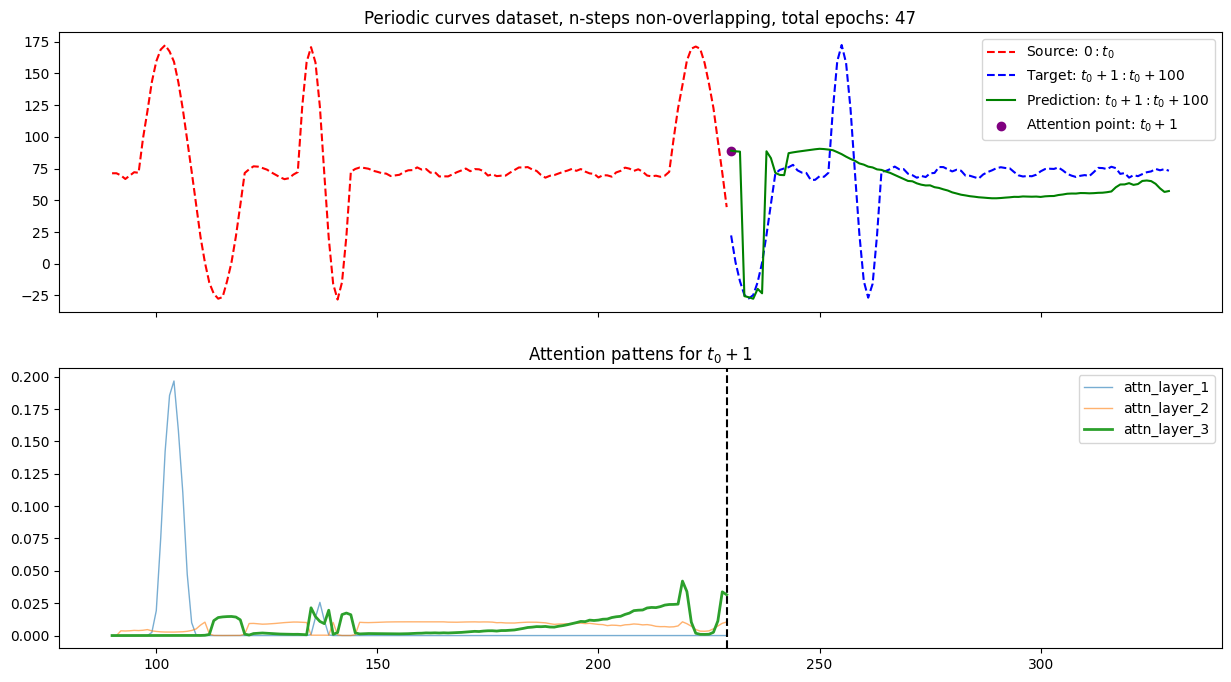

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple',
            label=f"Attention point: $t_0 + {inspect_step + 1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers - 1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i + 1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i + 1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step + 1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{str(n_shifts)}_shifted_attn.pdf", dpi=1200)

# 3 Shifts

In [49]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140  # sequence length of each sample
n_timeseries = 1  # number of multivariate time series
shift = 100  # number of steps to predict at once
total_length = 6000 + seq_len + shift  # full length of timeseries
n_shifts = 3  # number of shifts in shift attention

# attention module
_attention = ShiftAttention(shift=n_shifts)

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100,
                                   mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

### Training setup

In [50]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [51]:
early_stopper.reset()

for epoch in range(EPOCHS):
    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift,
                                                      device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(
        f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
        
model = early_stopper.best_model

epoch=0	train_loss=2401.9382	val_loss=1557.8189	train_mape_loss=2.0370	val_mape_loss=1.9619	R_p=['0.3280', '0.4129']
epoch=1	train_loss=1506.9121	val_loss=1552.0773	train_mape_loss=2.2862	val_mape_loss=1.9667	R_p=['0.3247', '0.4061']
epoch=2	train_loss=1501.4351	val_loss=1497.7591	train_mape_loss=2.2856	val_mape_loss=1.9945	R_p=['0.3011', '0.3592']
epoch=3	train_loss=1444.3466	val_loss=1450.4240	train_mape_loss=2.2566	val_mape_loss=1.8675	R_p=['0.3182', '0.4068']
epoch=4	train_loss=1362.5881	val_loss=1482.3460	train_mape_loss=2.1673	val_mape_loss=1.7330	R_p=['0.3228', '0.4318']
epoch=5	train_loss=1328.1645	val_loss=1293.3980	train_mape_loss=2.1098	val_mape_loss=1.5810	R_p=['0.2689', '0.3466']
epoch=6	train_loss=1280.3126	val_loss=1257.7801	train_mape_loss=2.0595	val_mape_loss=1.6384	R_p=['0.2522', '0.3047']
epoch=7	train_loss=1251.0051	val_loss=1245.2603	train_mape_loss=2.0228	val_mape_loss=1.6405	R_p=['0.2564', '0.3139']
epoch=8	train_loss=1190.9129	val_loss=1243.1052	train_mape_loss=

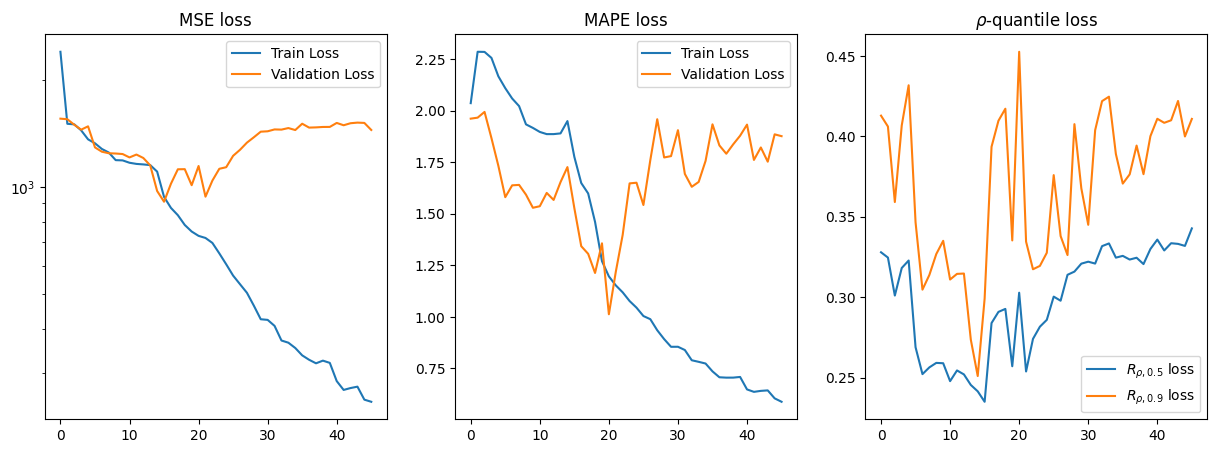

In [52]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [53]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(911.3307314453125,
 1.6851833276748658,
 [0.2375456988811493, 0.30293571949005127])

### Predict

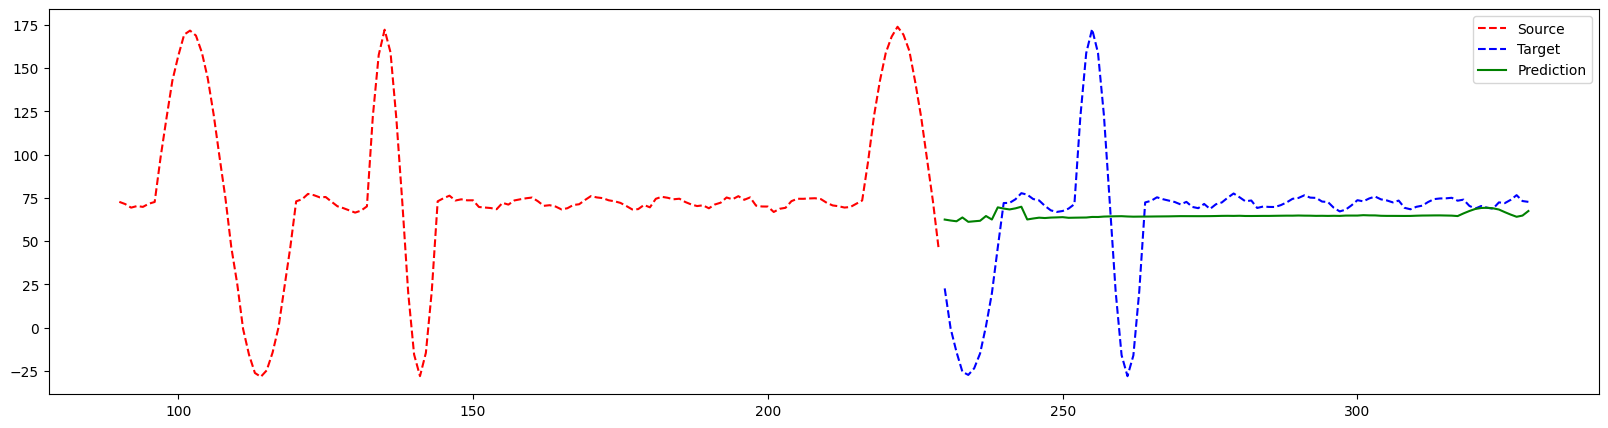

In [54]:
idx = 90  # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [55]:
inspect_step = 0

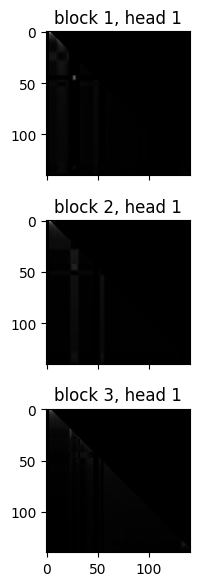

In [56]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2 * n_heads, 2 * n_layers), sharex=True, sharey=True,
                         squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i + 1}, head {j + 1}")
plt.tight_layout()

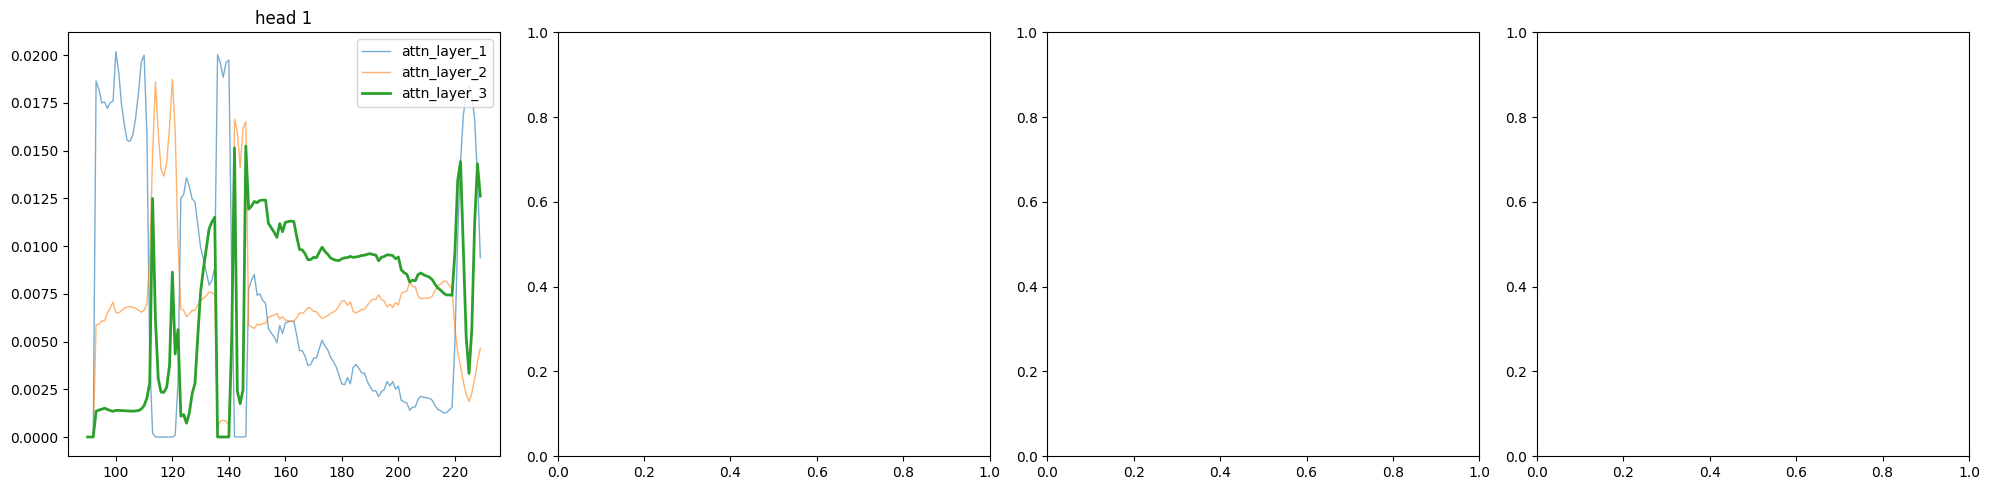

In [57]:
fig, axes = plt.subplots(n_heads // 4 + 1, 4, figsize=(20, 5 + n_heads // 4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step - 1, :].cpu()
        if i == n_layers - 1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i + 1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i + 1}')
        ax.set_title(f"head {j + 1}")
    ax.legend()

plt.tight_layout()

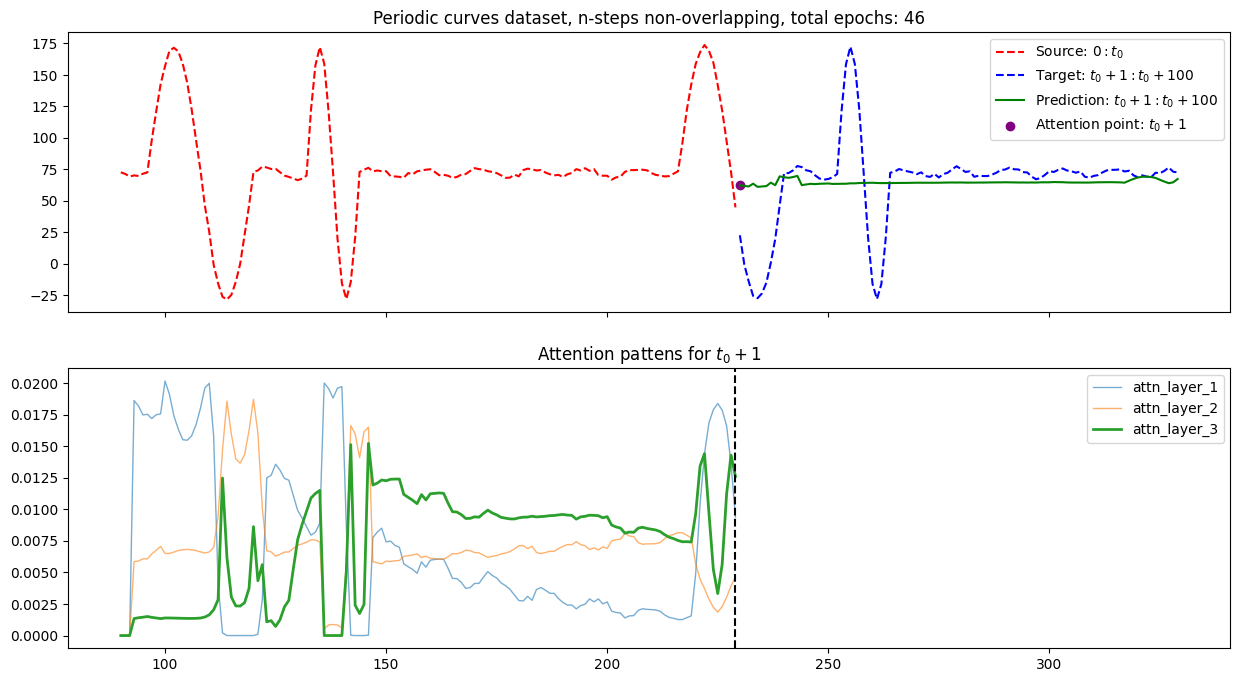

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple',
            label=f"Attention point: $t_0 + {inspect_step + 1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers - 1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i + 1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i + 1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step + 1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{str(n_shifts)}_shifted_attn.pdf", dpi=1200)

# 4 shifts

In [59]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140  # sequence length of each sample
n_timeseries = 1  # number of multivariate time series
shift = 100  # number of steps to predict at once
total_length = 6000 + seq_len + shift  # full length of timeseries
n_shifts = 4  # number of shifts in shift attention

# attention module
_attention = ShiftAttention(shift=n_shifts)

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100,
                                   mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

### Training setup

In [60]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [61]:
early_stopper.reset()

for epoch in range(EPOCHS):
    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift,
                                                      device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(
        f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break
        
model = early_stopper.best_model

epoch=0	train_loss=2396.0672	val_loss=1563.8816	train_mape_loss=2.2331	val_mape_loss=2.2218	R_p=['0.3339', '0.4243']
epoch=1	train_loss=1504.5683	val_loss=1556.1047	train_mape_loss=2.5745	val_mape_loss=2.2233	R_p=['0.3297', '0.4155']
epoch=2	train_loss=1503.2879	val_loss=1537.3621	train_mape_loss=2.5600	val_mape_loss=2.1905	R_p=['0.3245', '0.4060']
epoch=3	train_loss=1455.1363	val_loss=1481.2725	train_mape_loss=2.4375	val_mape_loss=2.0081	R_p=['0.3160', '0.4003']
epoch=4	train_loss=1314.5172	val_loss=2094.0281	train_mape_loss=2.1769	val_mape_loss=2.0354	R_p=['0.4002', '0.5683']
epoch=5	train_loss=1142.2759	val_loss=1869.9364	train_mape_loss=1.9553	val_mape_loss=2.4499	R_p=['0.3802', '0.4594']
epoch=6	train_loss=978.9004	val_loss=1669.6401	train_mape_loss=1.8541	val_mape_loss=2.6245	R_p=['0.3657', '0.3765']
epoch=7	train_loss=884.1619	val_loss=1690.0834	train_mape_loss=1.5996	val_mape_loss=2.6869	R_p=['0.3505', '0.3497']
epoch=8	train_loss=808.6422	val_loss=1586.5577	train_mape_loss=1.4

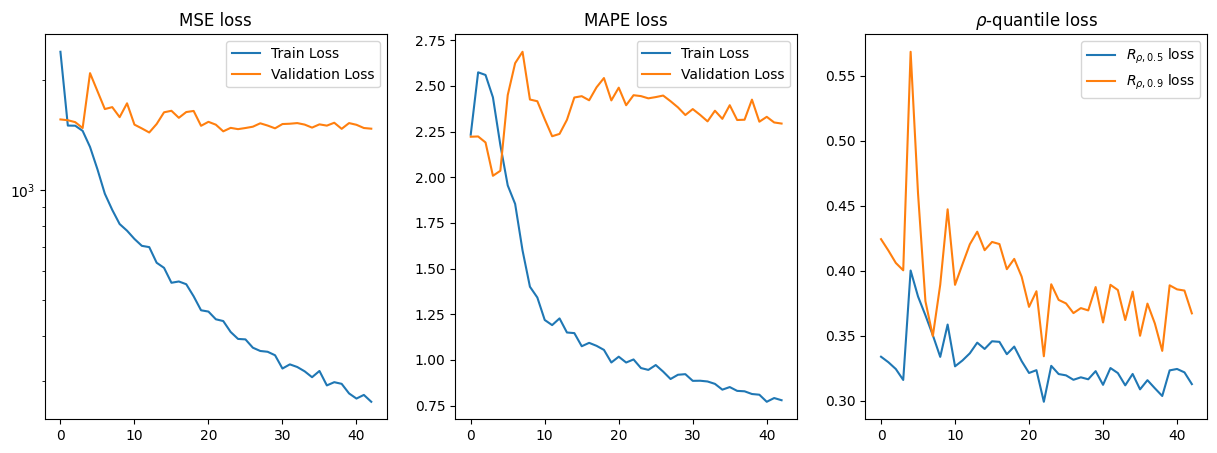

In [62]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [63]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(1450.2429794921875,
 2.321102899551392,
 [0.3388659656047821, 0.42137718200683594])

### Predict

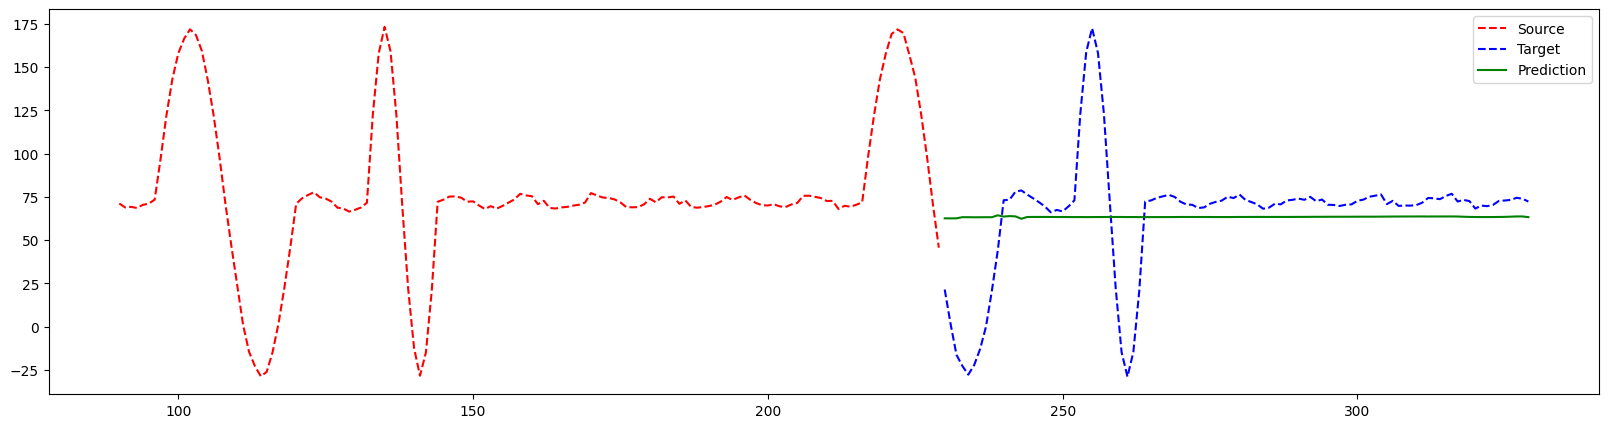

In [64]:
idx = 90  # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [65]:
inspect_step = 0

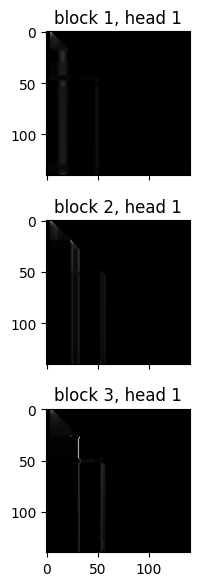

In [66]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2 * n_heads, 2 * n_layers), sharex=True, sharey=True,
                         squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i + 1}, head {j + 1}")
plt.tight_layout()

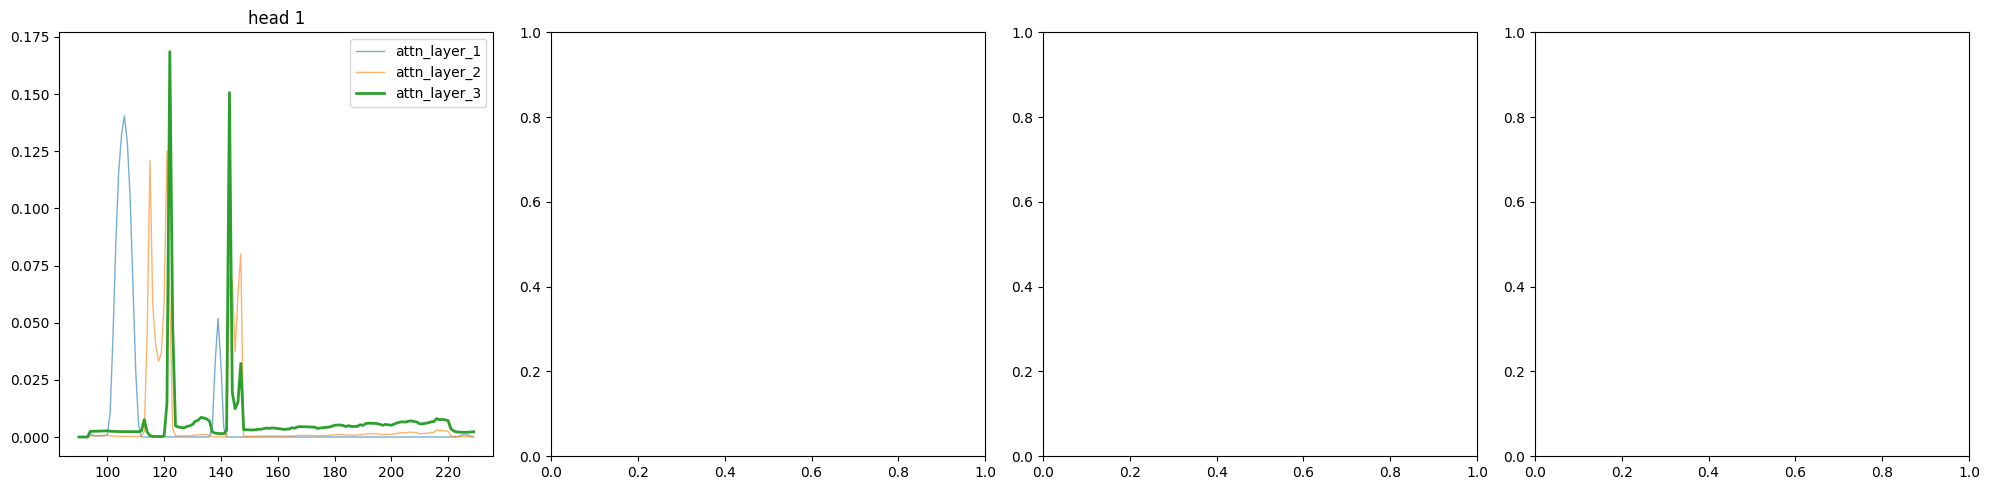

In [67]:
fig, axes = plt.subplots(n_heads // 4 + 1, 4, figsize=(20, 5 + n_heads // 4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step - 1, :].cpu()
        if i == n_layers - 1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i + 1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i + 1}')
        ax.set_title(f"head {j + 1}")
    ax.legend()

plt.tight_layout()

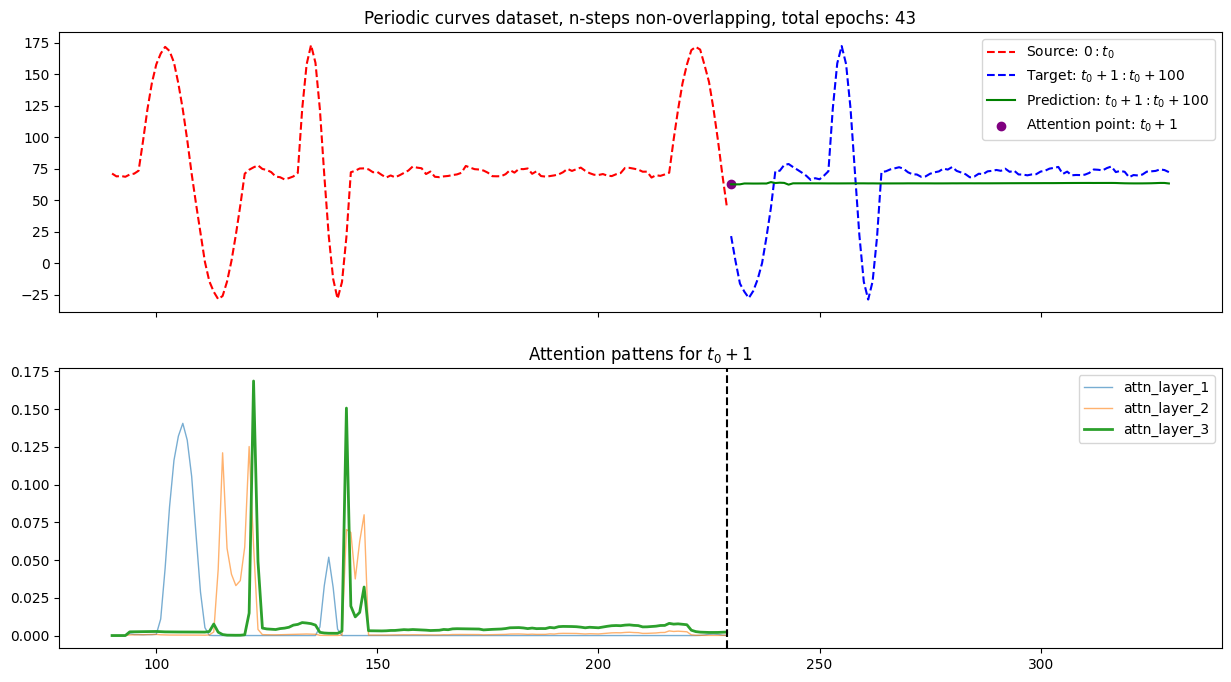

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple',
            label=f"Attention point: $t_0 + {inspect_step + 1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):w
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers - 1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i + 1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i + 1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step + 1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{str(n_shifts)}_shifted_attn.pdf", dpi=1200)
